<div dir=rtl align=center>

<img src='https://upload.wikimedia.org/wikipedia/fa/thumb/a/a9/Sharif_logo.svg/626px-Sharif_logo.svg.png?20110526112825' alt="SUT logo" width=200 height=200 align=center  >
<br>
<font face="B Yekan">
<font color=0F5298 size=7>
یادگیری ماشین<br>
<font color=2565AE size=5>
دانشکده مهندسی صنایع<br>
<font color=2565AE size=4>
دکتر مهدی شریف زاده <br>
<font  size=4>
 سعیدرضا زواشکیانی <br>
بهار 1402<br>

<font color=3C99D size=5>
طبقه بندی<br>
    
    
    
____


# Setup

In [4]:

# Scikit-Learn ≥0.20 is required
import sklearn
import numpy as np
# to make this notebook's output stable across runs
np.random.seed(42)
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# MNIST

In [5]:
mnist = pd.read_csv('mnist_784.csv')


In [6]:
X, y = mnist.iloc[:, :-1].values, mnist.iloc[:, -1].values

In [7]:
X.shape

(70000, 784)

In [8]:
28 * 28

784

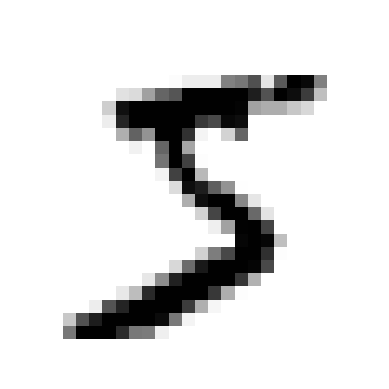

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [10]:
y[0]

5

In [11]:
y = y.astype(np.uint8)

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

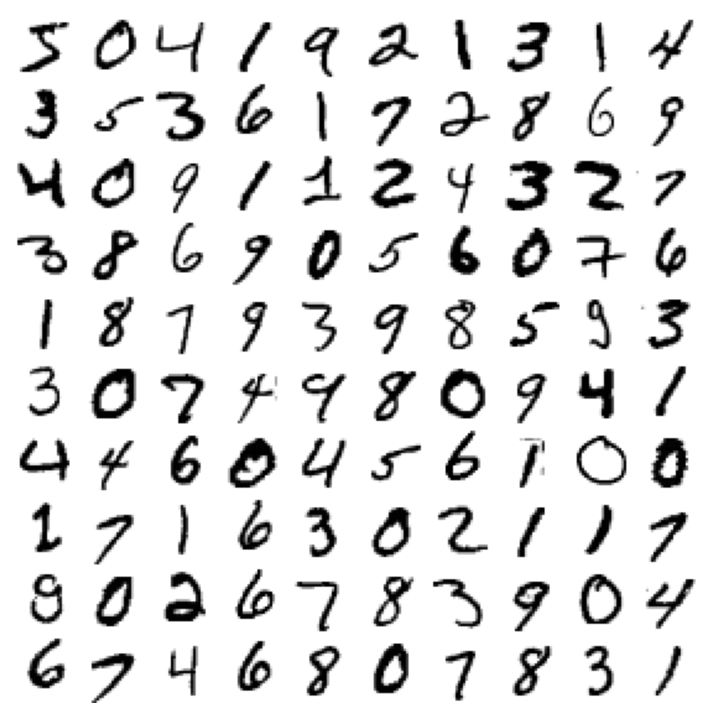

In [14]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [15]:
y[0]

5

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let's simplify the problem for now and try to identify one digit (number **5**). This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.

Let's create the target vector for the classification task:

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above $95\%$ accuracy, isn't that great?

Let's look at the performance of a very dumb classifier that classifies all training rows as "Not-5":

In [21]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=int)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The dumb classifier has over 90% acccuracy for any validation. This happened because of the class imabalance in the binary task we are aiming for.
    
We originally had balanced counts for each digit. But when we turned the problem into `5 vs. non-5`, we ended up with the first class taking `~10%` of the rows and non-5 taking `>=90%`. Hence, if we create a dumb model that just predicts "non-5" for any input, you'll get at least 90% accuracy.

This demonstrates why accuracy is generally not the preferred method to evaluate classifiers, especially if the data have imbalanced classes.

## Confusion Matrix

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`corss_val_predict` returns the predictions made of the test fold and because we are looping over the 3 folds, we endup with predictions for all data.

Let's take a look at the confusion matrix:

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in the confusion matrix represents an actual class. While each column represents a predicted class.

- first row is "not 5": Model correctly predicted "not 5" for 26K "not 5"s (True Negatives).
- Model incorrectly predicted "5" for 776 "not 5"s (False Positives).
- second row is "5": Model incorrectly predicted "not 5" for 529 "5"s (False Negative)
- Model correctly predicted "5" for 2180 "5"s (True Positives)

A perfect classifier would have only True Positives and True negatives, meaning the confusion matrix will have zeros on all elements except its diagonal.

Let's pretend we reached perfection:

In [25]:
y_train_perfect_predictions = y_train_5.copy()  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives us a lot of information, but sometimes you may prefer a single-number metric. 

An interesting one to look at is the model's accuracy over its positive predictions, named *precision*:

$$precision = \frac{TP}{TP+FP}$$

A trivial way to have a perfect precision of $1$ is to make one prediction that you're sure it's correct, by consequence $FP=0$ and $precision=1$. This would not be useful since the evaluation is ignore all but the true positives.

Precision is typically used along with another metric named recall. 

Recall, also called sensitivity or the True Positive rate is as follows:

$$recall = \frac{TP}{TP+FN}$$

## Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [27]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [29]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

The recall score is not good at all.

Its dominator consists of TPs & **False Negatives**. We can conclude that our model is predicting a lot of digits as not "5" but they're "5"s. The model is not good at predicting False Negatives.

Now our model doesn't look as shiny as it was when we looked at its accuracy. When it claims that a digit represents a "5" it's only correct for $80\%$ of the times.

It's often convinient to combine the precision and accuracy scores into a single metric called the $F_{1}$ score. In particular, if we want to compare two classifiers.

The $F_{1}$ score represents the harmonic mean of the precision & recall metrics. It is harmonic because it gives more importance to low values in its formula. 

Meaning, the F1 score will only give you high scores if both precision and recall are high.

$$F_{1}=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2 \times \frac{precision \times recall}{precision + recall}$$

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

The $F_{1}$ favors classifiers that have similar precision and recall. But this is not always what we would want:

Sometimes we only care about precision (the relation between True Positives and **False Positives**). Ex: we don't want to incorrectly predict that a bad video is safe for kids to watch, but you don't care that much if you incorrectly predict that a video is bad.

Other times we only care about recall (the relation between True Positives and **False Negatives**). Ex: we don't want to incorrectly predict that a person doesn't have cancer.

Unfortunately, we can't have it both ways, increasing precision will decrease recall, and increasing recall decreases precision.

This is called the precision-recall trade-off.

## Precision/Recall Trade-off

`Scikit-learn` doesn't allow us to set the threshold directly, but it can give us the scores for each of its prediction.

We can set the threshold we want after getting the scores:

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([ True])

In [35]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do we decide which threshold to use?

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these decision scores, we use another function to compute the recalls/precisions for all possible threshold:

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

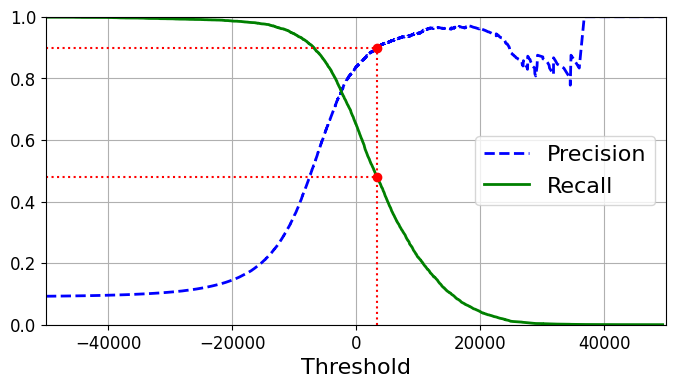

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                             
plt.show()

We may wonder why the precision curve is bumpier than the recall curve. The reason is that the precision may sometimes go down when we raise the threshold. We may lose precision by upping the threshold if we lose TPs while the FPs are still there, but generally, precision should increase.

On the other hand, recall is very smooth because we add another TN while moving the threshold, nothing changes in the score.

Another way to select a good precision and recall trade-off is to plot precision directly against recall:

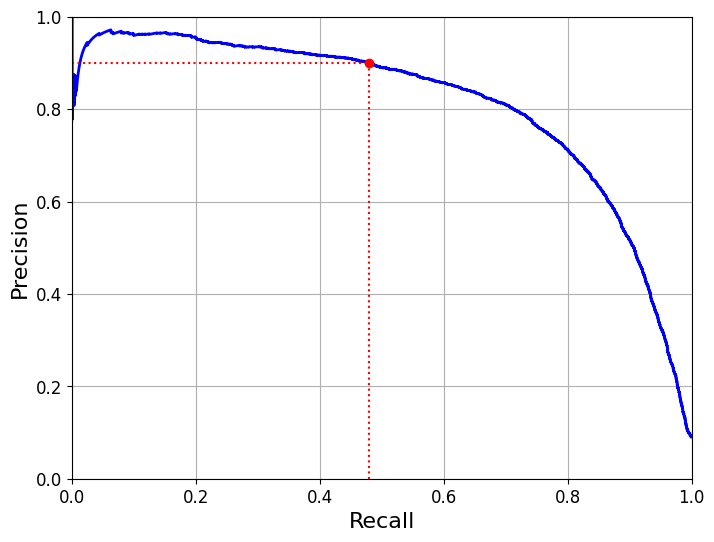

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [42]:
threshold_90_precision

3370.0194991439557

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

We can see the precision really starts to fall sharply around 80% recall.

We would probably want to select a precision/recall trade-off just before **that drop** (For example, at around $60\%$ recall). But ofcoures, the choice depends on the project.

Suppose we want to aim for $90\%$ precision, we would look up the first graph to get the threshold and lookup the second graph to find the best Recall we can get with a precision of $90\%$.

We should remember that a high precision classifier is not good at all with a low recall.

If someone shouts: "Let's reach a 99% precision score", you should ask: "But at what Recall?"

## The ROC Curve

The receiver operating characteristic curve is another tool used with binary classifiers. ROC plots TP rate versus FP rate.

ROC plots recall versus 1 - specificity

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

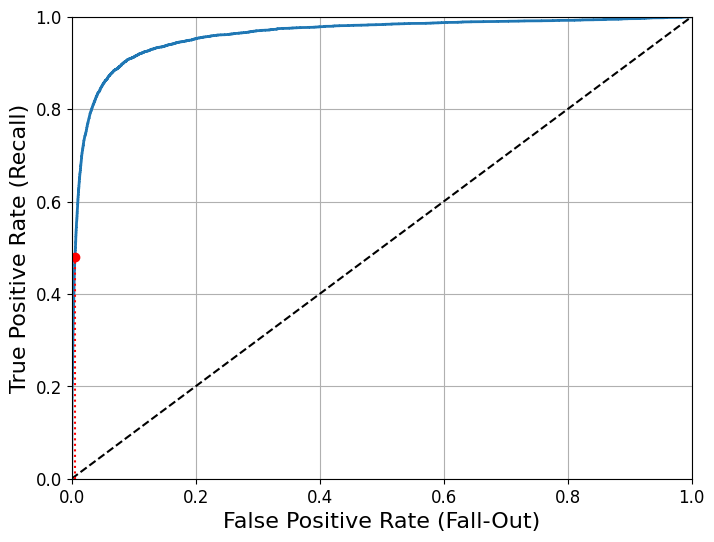

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")                                          # Not shown
plt.show()

The Higher the recall, the more false positives the model produces.

The dotted line represent the ROC curve of a completely random classifier. A good classifier stays as far a way as possible from the dotted line.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an ROC AUC of 1 and a purely random classifier will have an ROC AUC of 0.5.

Example:

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

now use RandomForestClassifier:

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

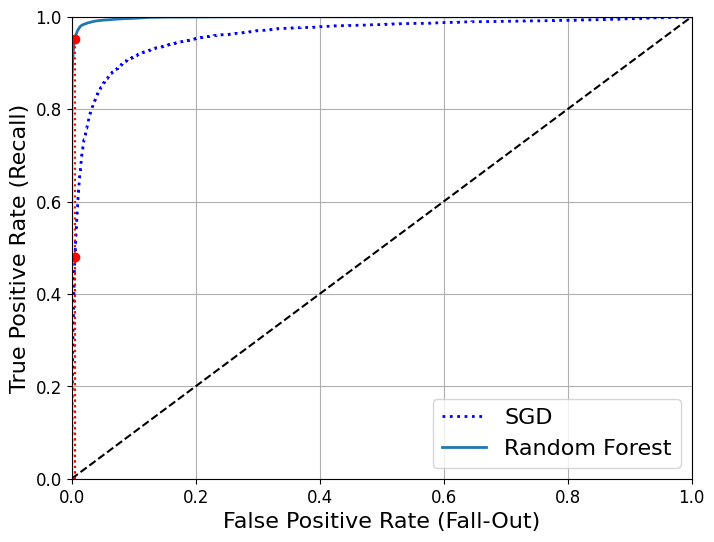

In [51]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification

There are techniques we can use to perform multiclass classification with binary classifiers. One way to create a system that can classify an image into 10 labels (from 0 to 9) is to train 10 binary classifiers (one for each digit). 

Then when we want to classify an image, we get each classifier's associated positive score and pick the model class w/ the highest score. This is called one-versus-the-rest startegy, or 1-vs-all.

Another startegy is to train a binary classifier for each pair of digits. This is called 1-vs-1. If there are $N$ classes, we would need to train $\frac{N \times (N-1)}{2}$. For the MNIST Problem, this means training $45$ binary classifiers. The class which wins the most duals is the predicted one.

Even though we need to create many classifiers, they are needed to be trained on only the data points where one of the classes appeared.

`Scikit-learn` detects when we try to use a binary classification algorithm for a multiclass classification problem, it then automatically use OvO or OvR depending on the algorithm to train.

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In this case, the Support Vector Classifier used `OvO` to predict the class of `some_digit`. It tried $N*(N-1)/2$ classifier for all pairs of classes.

After inputing a new sample, it runs all `45` trained models and picks the one who won the most duals.

If we inspect the score for a specific instance input, we will notice that the model outputs 10 scores, for each digit. Giving us a performance measure of each digit versus all others. 

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [57]:
np.argmax(some_digit_scores)

5

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

5

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

10

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

If this was a real machine learning project, we would need to follow the steps in the checklist:
- Explore data preparation options.
- Try out, shortlisting, & hyper-parameter finetuning multiple models.
- Automate as much as possible.

Here, we will assume that we have found a promissing model and that we want to improve it. One of the few ways is to analyze the types of errors it makes.

First, let's look at the confusion matrix

In [66]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [67]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

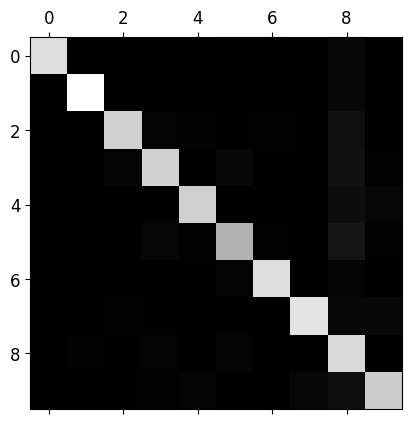

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let's focus the plot on the errors. Instead of plotting the absolute numbers, we will plot counts over the number of images of the class:

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

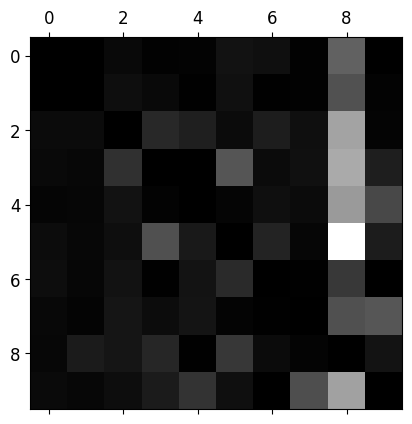

In [70]:
#Then we fill the diagonal with zeros to highlight only the errors:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kind of errors the classifier makes. Remember that the rows represent acutal labels and the columns represent the predicted class.

The column of class `8` is quite bright, which tells us that many input images get misclassified as `8`s. However, the row for 8s is not that bad, telling us that when given input images of 8s, the model does a good job of classifying them as 8s.

As we can see, the confusion matrix is not necessarly symmetrical. In our specific example, `3`s and `5`s are often confused.

Analyzing the confusion matrix often gives us insights into how to improve the classifier itself.

Looking at this plot, it seems that our efforts should be focused on reducing the false 8s. For example, we could try collecting images of digits that look like 8s but are not, then training the classifier to better distinguish.

Analyzing our errors could be also a good way into knowing what the model is learning and why is it failling.

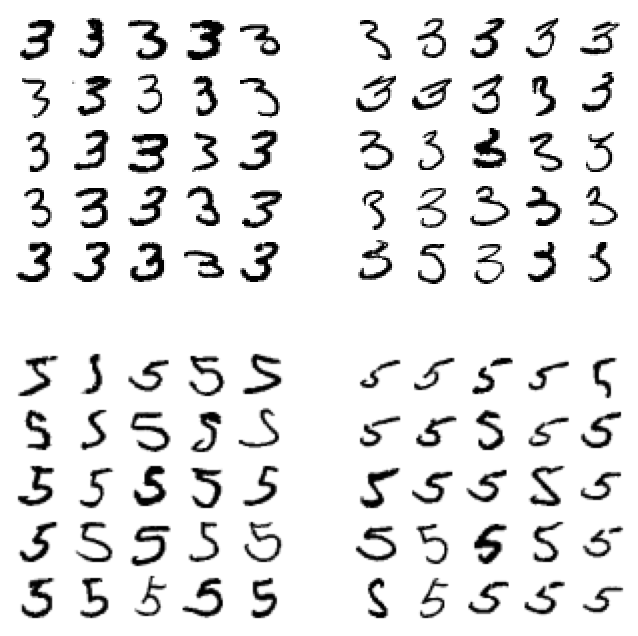

In [71]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two `5x5` blocks on the left show instances classified as `3`s, and the two `5x5` blocks on the right show instances classified as `5`s.

Most misclassifed images seem like obvious mistakes to us and it's hard for us to understand why the classifier made the mistakes it did.

The true reason is that when we used `SGDClassifier`, which is a linear model, it just assigns weights to each pixel, and when it gets a new image, it sums up the pixel intensities times the trained weights, and since 5s and 3s share most of the pixel intensity locations, the model get sometimes confused.

The main difference between a `5` and a `3` is the position of the small line that joins the top line to the bottom arc.

Meaning that if we draw a 3 with a slightly shifted line to the left, the classifier might assign it a 5, and same to 5s classified as 3s.

In other words, this classifier is quite sensitive to image rotation and shifting. **So one way to reduce errors is to preprocess the images to make sure the digits are well centered and not too rotated**.

# Multilabel Classification

In some cases, we want our classifier to output multiple classes per instance (e.g. Face recognition in images). 

What should it do when it recognizes several people in a picture?

Such system that outputs multiple binary scores that don't necessarly sum up to 1 is called a multilabel classifier.

Let's go through a simple example:

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [74]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput Classification

The last type of classification we will discuss is called multioutput-multiclass classification (Ex. Identifying animals in a picture & for each animal we have N classes). Meaning, each label can be multiclass.

To demonstrate this, let's build a system that removes noise from images. It will take the noisy digit images as input, and will hopefully output an image that look like the original one from the dataset. Notice that the system is a multioutput classification one (Output: 728 pixels, each pixel intensity ranges from 0 to 255).

Let's start with training data by adding a mask of noise, the original image will serve as the output (target):

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

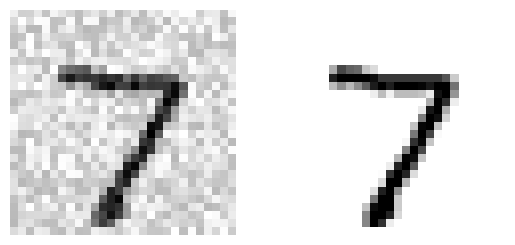

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

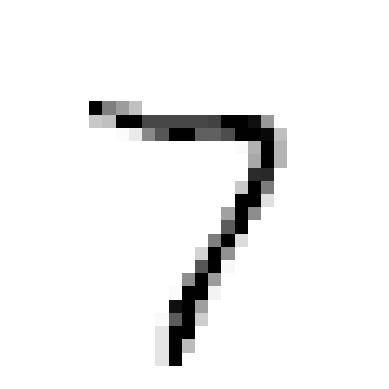

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Extra material

## Dummy (ie. random) classifier

In [78]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

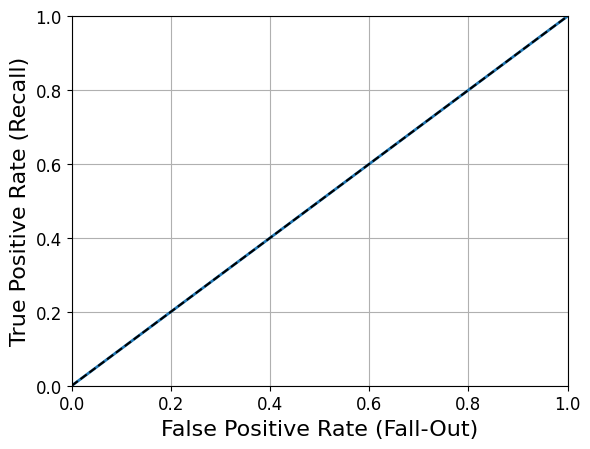

In [79]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
y_knn_pred = knn_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_13820\3518175631.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


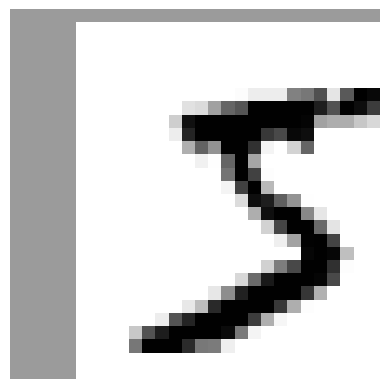

In [83]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [84]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [85]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [86]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [87]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

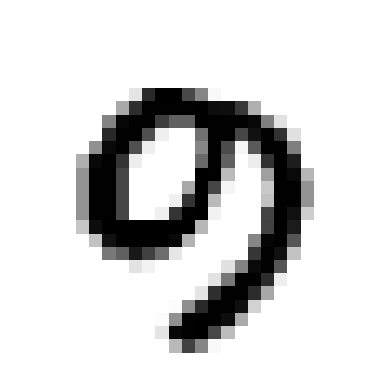

In [89]:
plot_digit(ambiguous_digit)